# Forest Cover Prediction (notebook 2)


In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


notes:
    - https://www.youtube.com/watch?v=q5Y3ufgd_tQ

In [19]:
import pandas as pd
from pathlib import Path

# path Path to have a ls method
Path.ls = lambda x: list(x.iterdir())

In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted):
     return sqrt(mean_squared_error(y_actual, y_predicted))

def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    

In [20]:
p = Path('/data/ifu/summerschool')
p.ls()

[PosixPath('/data/ifu/summerschool/df_train.csv'),
 PosixPath('/data/ifu/summerschool/covtype.data.gz'),
 PosixPath('/data/ifu/summerschool/covtype.data'),
 PosixPath('/data/ifu/summerschool/forestcover_02.ipynb'),
 PosixPath('/data/ifu/summerschool/forestcover_01.ipynb'),
 PosixPath('/data/ifu/summerschool/original.datasets'),
 PosixPath('/data/ifu/summerschool/model_setup_and_training_summerschool.ipynb'),
 PosixPath('/data/ifu/summerschool/df_test.csv'),
 PosixPath('/data/ifu/summerschool/.ipynb_checkpoints'),
 PosixPath('/data/ifu/summerschool/testdir'),
 PosixPath('/data/ifu/summerschool/df_valid.csv'),
 PosixPath('/data/ifu/summerschool/covtype.info')]

## EDA

### Feature selection

In [230]:
df_train = pd.read_csv('df_train.csv') #, header=True)
df_valid = pd.read_csv('df_valid.csv') #, header=True)
df_all   = pd.concat([df_train, df_valid])

print(df_all.shape)

X_train, y_train = df_train.drop('Cover_Type', axis=1).values, df_train['Cover_Type'].values
X_valid, y_valid = df_valid.drop('Cover_Type', axis=1).values, df_valid['Cover_Type'].values
X_all, y_all = df_all.drop('Cover_Type', axis=1).values, df_all['Cover_Type'].values

(15120, 55)


In [231]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_all, y_all)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))

print_score(rf)


R^2 Training Score: 1.00 
OOB Score: 0.87 
R^2 Validation Score: 1.00
[0.0, 0.0, 1.0, 1.0, 0.8651455026455026]


Feature ranking (top10):
1. feature 0 (0.21927835132327556)
2. feature 5 (0.09955239982568395)
3. feature 9 (0.07193250255656629)
4. feature 3 (0.06397287853839478)
5. feature 4 (0.053189572432907666)
6. feature 6 (0.05004521890127094)
7. feature 1 (0.049827776518972904)
8. feature 8 (0.04573993065725695)
9. feature 7 (0.04460298898503132)
10. feature 13 (0.03828114734588653)


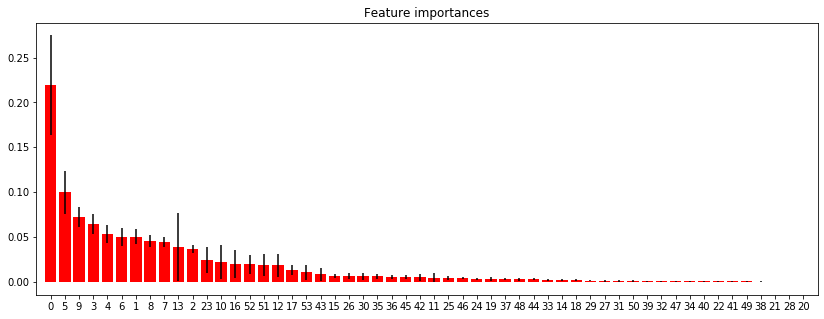

In [232]:
import numpy as np

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking (top10):")

for f in range(X_all.shape[1])[:10]:
    print(f"{f+1}. feature {indices[f]} ({importances[indices[f]]})")


# Plot the feature importances of the forest
import matplotlib.pylab as plt
plt.figure(figsize=(14,5))
plt.title("Feature importances")
plt.bar(range(X_all.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_all.shape[1]), indices)
plt.xlim([-1, X_all.shape[1]])
plt.show()

In [57]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# a single tree

In [233]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_all, y_all)
print_score(m)

[2.189420610624938, 2.200709361347312, 0.3628747795414462, 0.3634920634920635]


In [127]:
#draw_tree(m.estimators_[0], df_trn, precision=3)

# Check this out
https://explained.ai/decision-tree-viz/
    

In [45]:
! pip install dtreeviz

In [234]:
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_all, y_all)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [235]:
features = list(df_all.columns[:-1].values)
ctypes = {1:'Spruce/Fir',
          2:'LodgepolePine',
          3:'PonderosaPine',
          4:'Cottonwood/Willow',
          5:'Aspen',
          6:'Douglas-fir',
          7:'Krummholz'}


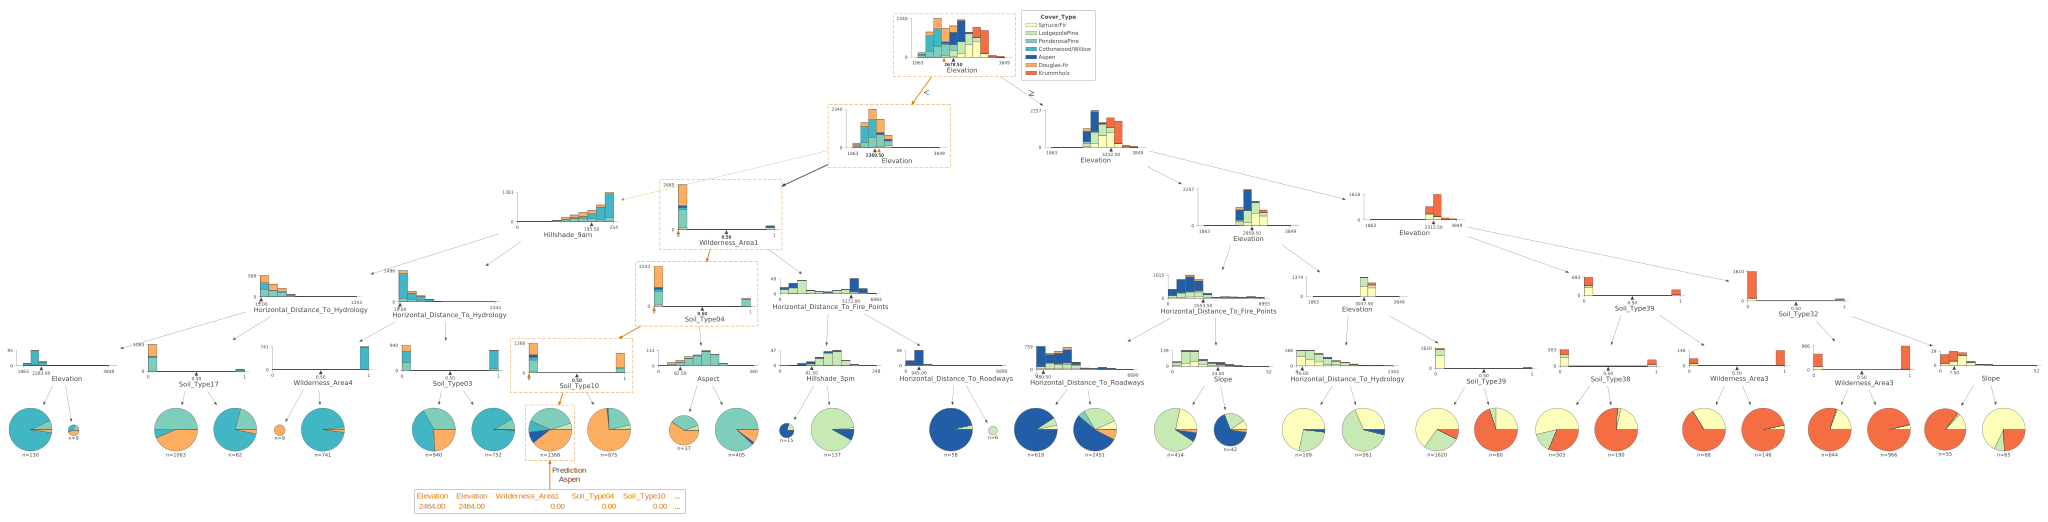

In [236]:
from dtreeviz.trees import *
#classes=list(range(1,8))

X = X_all[np.random.randint(0, len(X_all)),:]


viz = dtreeviz(dtc,
               X_all, y_all,
               target_name='Cover_Type',
               feature_names=features,
               class_names=ctypes,
               X=X)
viz

In [288]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

# Make an instance of the Model
pca = PCA(n_components=2)


pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])
pc = pipeline.fit_transform(X_all)

df_pca  = pd.DataFrame(data = pc, columns = ['pc1', 'pc2'])
df_pca['Cover_Type'] = y_all
df_pca['Cover_Type'] = df_pca.Cover_Type.map(ctypes)
df_pca.head()

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,pc1,pc2,Cover_Type
0,-2.377993,2.090411,Aspen
1,-2.349104,1.994033,Aspen
2,-3.169676,1.967211,LodgepolePine
3,-2.378859,2.683257,LodgepolePine
4,-2.275038,2.065737,Aspen


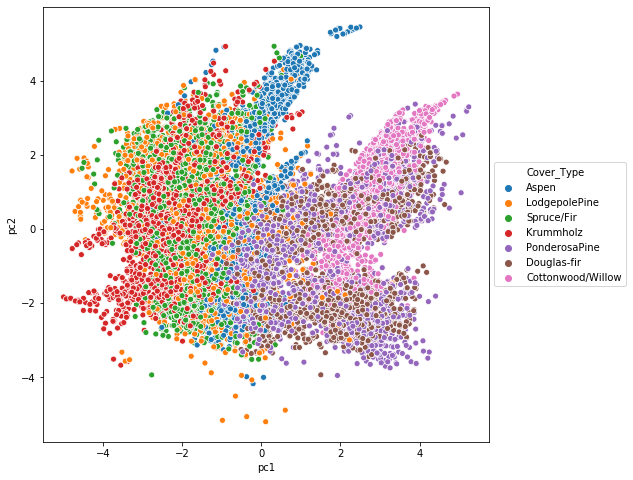

In [289]:
import seaborn as sns
plt.figure(figsize=(8,8))

g=sns.scatterplot(data=df_pca, x='pc1', y='pc2', hue='Cover_Type')
g.legend(loc="center left", bbox_to_anchor=(1.0, 0.5));

In [291]:
pipeline_lda = Pipeline([('scaling', StandardScaler()), ('lda', LinearDiscriminantAnalysis(n_components=2))])
lda = pipeline_lda.fit_transform(X_all, y_all)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [292]:
df_lda  = pd.DataFrame(data = lda, columns = ['lda1', 'lda2'])
df_lda['Cover_Type'] = y_all
df_lda['Cover_Type'] = df_lda.Cover_Type.map(ctypes)
df_lda.head()

,lda1,lda2,Cover_Type
0,-0.561777,-1.979931,Aspen
1,-0.568861,-1.946284,Aspen
2,-1.932919,-1.906679,LodgepolePine
3,-0.875701,-1.768020,LodgepolePine
4,-0.594729,-1.899466,Aspen


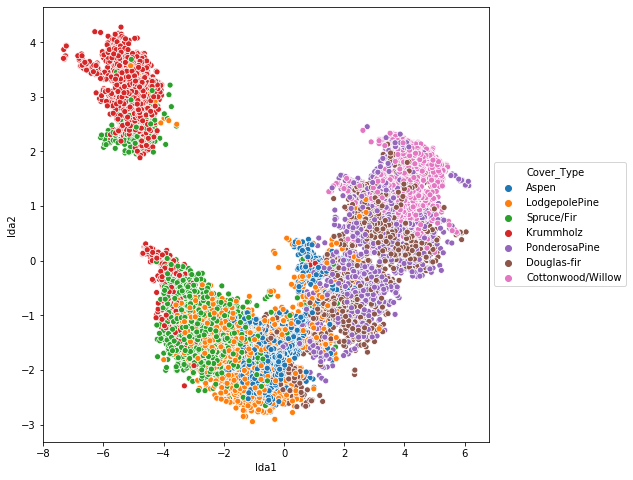

In [293]:
plt.figure(figsize=(8,8))

g=sns.scatterplot(data=df_lda, x='lda1', y='lda2', hue='Cover_Type')
g.legend(loc="center left", bbox_to_anchor=(1.0, 0.5));

In [239]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(X_all)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 15120 samples in 0.022s...
[t-SNE] Computed neighbors for 15120 samples in 2.571s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15120
[t-SNE] Computed conditional probabilities for sample 2000 / 15120
[t-SNE] Computed conditional probabilities for sample 3000 / 15120
[t-SNE] Computed conditional probabilities for sample 4000 / 15120
[t-SNE] Computed conditional probabilities for sample 5000 / 15120
[t-SNE] Computed conditional probabilities for sample 6000 / 15120
[t-SNE] Computed conditional probabilities for sample 7000 / 15120
[t-SNE] Computed conditional probabilities for sample 8000 / 15120
[t-SNE] Computed conditional probabilities for sample 9000 / 15120
[t-SNE] Computed conditional probabilities for sample 10000 / 15120
[t-SNE] Computed conditional probabilities for sample 11000 / 15120
[t-SNE] Computed conditional probabilities for sample 12000 / 15120
[t-SNE] Computed conditional probabilities for sa

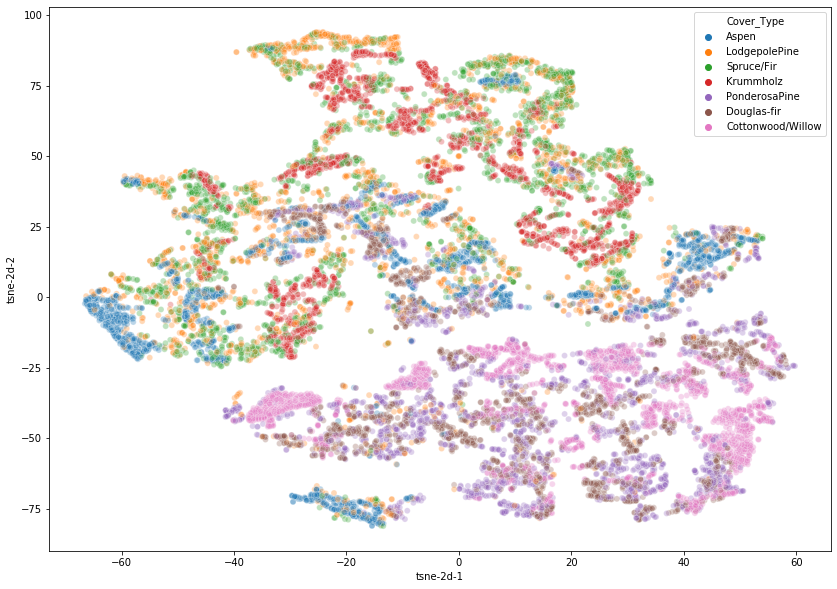

In [241]:
df_tsne  = pd.DataFrame(data = tsne_results, columns = ['tsne-2d-1', 'tsne-2d-2'])
df_tsne['Cover_Type'] = y_all
df_tsne['Cover_Type'] = df_tsne.Cover_Type.map(ctypes)

plt.figure(figsize=(14,10))
sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="Cover_Type",
    #palette=sns.color_palette("hls", 10),
    data=df_tsne,
    legend="full",
    alpha=0.3
)

## Classifications
- logistic regression
- lightgbm
- xgboost
- random forest

https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm


Move to serperate notebook later...  

In [257]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

In [249]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

In [250]:
%%time
rf.fit(X_train, y_train)

CPU times: user 1.32 s, sys: 20 ms, total: 1.34 s
Wall time: 445 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [252]:
rf_val_pred = rf.predict(X_valid)
accuracy_score(y_valid, rf_val_pred)

0.8505291005291006

In [ ]:
logit = LogisticRegression(C=1, solver='lbfgs', max_iter=500,
                           random_state=42, n_jobs=4,
                           multi_class='multinomial')

logit_pipe = Pipeline([('scaler', StandardScaler()), 
                       ('logit', logit)])

In [246]:
%%time
logit_pipe.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


CPU times: user 1.42 s, sys: 40.3 ms, total: 1.46 s
Wall time: 2 s


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='multinomial',
          n_jobs=4, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [247]:

logit_val_pred = logit_pipe.predict(X_valid)
accuracy_score(y_valid, logit_val_pred)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.7150793650793651

In [254]:
xgb = XGBClassifier(random_state=42)

In [255]:
%%timeit
xgb.fit(X_train, y_train)


7.61 s ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [256]:
xgb_val_pred = xgb.predict(X_valid)
accuracy_score(y_valid, xgb_val_pred)

0.7515873015873016

## Parameter tuning

In [295]:
parameters = {'learning_rate': [0.1, 0.01, 0.001], 
              'max_depth': [3, 5, 7, 9, 11]}

gsearcher = GridSearchCV(estimator=xgb, param_grid=parameters, 
                             cv=5, verbose=1, n_jobs=8)

In [296]:
gsearcher.fit(X_all, y_all)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 7, 9, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [297]:
gsearcher.best_params_, gsearcher.best_score_

({'learning_rate': 0.1, 'max_depth': 11}, 0.7840608465608465)